# Benchmark model - Impairment - Sequential Timewise Exploration, calibration, test

This notebook uses as inputs the outputs from the pipeline ('05_preproc_pipeline_1.ipynb' notebook) and performs model calibration and general exploration for the transaction credit events prediction.

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import environ

from sklearn.model_selection import cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scripts_viz.visualization_utils import *
from scripts_ml.models_utils import *

from bokeh.io import show, output_notebook
output_notebook()

import datetime as dt

Loading BokehJS ...

### TRAIN Data import

In [4]:
#importing data
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
prefix_time_seq = 'time_2018-04-30_p90_bg_'
valid_code = '_val_26000_2000_'
trainfile = '_traindata'
testfile = '_testdata'
postfix_time_seq_val = '_190824_1722' #'_190822_925'
postfix_time_seq = '_190824_1230' #'_190822_1031'
preproc_folder = "enriched_time_seq"
datafolder = "../data/preproc_traintest/"+preproc_folder+'/'
indexfile = '_fold_indexes'
expname = preproc_folder+"_p90"

[X_train, y_train, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+trainfile+postfix_time_seq+'.pkl') 
[X_test, y_test, feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+testfile+postfix_time_seq+'.pkl') 
[val_X_train, val_y_train, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+trainfile+postfix_time_seq_val+'.pkl') 
[val_X_test, val_y_test, val_feature_labels] = pd.read_pickle(datafolder+prefix_time_seq+valid_code+testfile+postfix_time_seq_val+'.pkl') 
indexes = pd.read_pickle(datafolder+prefix_time_seq+valid_code+indexfile+postfix_time_seq_val+'.pkl')

In [5]:
#recombining folds for grid search

val_X_all = []
val_y_all = []
indexes_tuples = []

count=0
start_tr=0

for idx in indexes:
    val_X_all.append(val_X_train[idx[0]])
    val_y_all.append(val_y_train[idx[0]])
    if count==0:
        test_idx = np.array(range(0, len(idx[1])))
    else:
        test_idx+=len(idx[1])
    val_X_all.append(val_X_test[test_idx])
    val_y_all.append(val_y_test[test_idx])
    
    
    if count==0:
        start_tst = len(idx[0])
    else:
        start_tr+=add_to_tr
        start_tst=start_tr+len(idx[0])
        
    indexes_tuples.append((np.array(range(start_tr, start_tr+len(idx[0]))), 
                          np.array(range(start_tst, start_tst+len(idx[1])))))
    
    add_to_tr = len(idx[0])+len(idx[1])
    
    count+=1
        

In [6]:
val_X_all = np.concatenate(val_X_all, axis=0)
val_y_all = np.concatenate(val_y_all, axis=0)

In [7]:
val_X_all.shape

(280101, 35)

In [8]:
val_X_all_df = pd.DataFrame(val_X_all, columns=feature_labels)
val_X_all_df.head()

,currency_Schweizer Franken,currency_Euro,currency_US-Dollar,currency_Britisches Pfund,has_purchase,dd_value_date,cd_lent_c,cd_repaid_c,cd_impaired1_c,cd_pastdue90_c,...,flow_shock_p90,p90_c_node_eff,p90_energy,p90_d_node_flow,flow_shock_p180,p180_d_node_flow,p180_energy,invoice_amount,purchase_amount,invoice_date
0,0.369065,-0.355531,-0.067676,-0.055794,-2.207857,0.295675,-0.595431,-0.446573,-0.17165,-0.080487,...,-0.333493,-0.324699,-0.299652,-0.219735,-0.333493,-0.219735,-0.299652,-0.804874,-2.152509,-4.047961
1,0.369065,-0.355531,-0.067676,-0.055794,-2.207857,0.295675,-0.584601,-0.446573,-0.17165,-0.080487,...,-0.333493,-0.324699,-0.299652,-0.219735,-0.333493,-0.219735,-0.299652,-0.159508,-2.152509,-4.047961
2,0.369065,-0.355531,-0.067676,-0.055794,-2.207857,0.295675,-0.573771,-0.446573,-0.17165,-0.080487,...,-0.333493,-0.324699,-0.299652,-0.219735,-0.333493,-0.219735,-0.299652,-0.512136,-2.152509,-4.047961
3,0.369065,-0.355531,-0.067676,-0.055794,-2.207857,0.295675,-0.595431,-0.446573,-0.17165,-0.080487,...,-0.333493,-0.479587,-0.299851,-0.353523,-0.333493,-0.353523,-0.299851,0.862278,-2.152509,-4.047961
4,0.369065,-0.355531,-0.067676,-0.055794,-2.207857,0.295675,-0.595431,-0.446573,-0.17165,-0.080487,...,-0.333493,-0.479587,-0.299851,-0.092210,-0.333493,-0.092210,-0.299851,0.361329,-2.152509,-4.047961


In [9]:
val_X_all_df.columns

Index(['currency_Schweizer Franken', 'currency_Euro', 'currency_US-Dollar',
       'currency_Britisches Pfund', 'has_purchase', 'dd_value_date',
       'cd_lent_c', 'cd_repaid_c', 'cd_impaired1_c', 'cd_pastdue90_c',
       'cd_trend_a', 'c_lent_c', 'c_repaid_c', 'c_impaired1_c',
       'c_pastdue90_c', 'c_trend_a', 'd_repaid_c', 'd_impaired1_c',
       'd_pastdue90_c', 'd_trend_a', 'd_we_payment_share', 'flow_shock_imp1',
       'imp_c_node_eff', 'imp_energy', 'imp_d_node_flow', 'flow_shock_p90',
       'p90_c_node_eff', 'p90_energy', 'p90_d_node_flow', 'flow_shock_p180',
       'p180_d_node_flow', 'p180_energy', 'invoice_amount', 'purchase_amount',
       'invoice_date'],
      dtype='object')

In [10]:
val_X_all_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
currency_Schweizer Franken,280101.0,-0.003694,1.005147,-3.909031,0.363264,0.369065,0.369065,0.369065
currency_Euro,280101.0,0.003138,1.005060,-0.355531,-0.355531,-0.355531,-0.349140,4.148166
currency_US-Dollar,280101.0,0.001023,1.010525,-0.087823,-0.069505,-0.067676,-0.067676,14.776201
currency_Britisches Pfund,280101.0,0.003364,1.011047,-0.055903,-0.055903,-0.055794,-0.055794,17.923018
has_purchase,280101.0,0.045768,0.952876,-2.441934,0.409511,0.452928,0.452928,0.482385
dd_value_date,280101.0,-0.051591,0.855729,-0.200817,-0.200817,-0.200817,-0.101562,88.242500
cd_lent_c,280101.0,0.034398,1.046857,-0.622501,-0.552112,-0.422154,0.068341,4.187600
cd_repaid_c,280101.0,0.049860,1.058373,-0.559044,-0.446573,-0.395194,-0.035540,4.612980
cd_impaired1_c,280101.0,0.018023,1.056658,-0.211258,-0.177347,-0.171650,-0.171650,8.151007
cd_pastdue90_c,280101.0,-0.001630,0.874858,-0.216470,-0.080487,-0.080487,-0.044333,22.556683


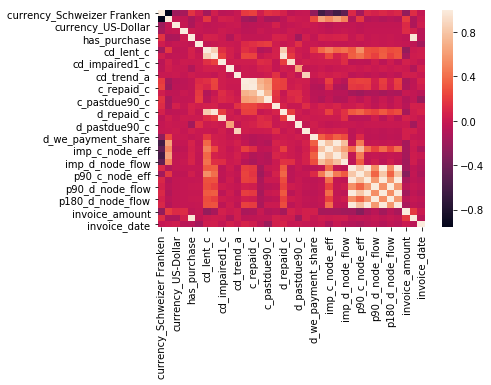

In [11]:
sns.heatmap(val_X_all_df.corr())

### SGD Classifier

In [12]:
#Linear model Stochastic Gradient Descent
sgd_clf = SGDClassifier(random_state=42, max_iter=250, loss='log', tol=0.0001) 
sgd_clf_diag = model_diag_seq(sgd_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26101 from index 0 to 26100, test on 2000 from 0 to 1999
Fold 1 AUC: 0.8335022873778332
Fold 2: train  on 26000 from index 2101 to 28100, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.4880465924569067
Fold 3: train  on 26000 from index 4101 to 30100, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.762175280620091
Fold 4: train  on 26000 from index 6101 to 32100, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.5958502089360334
Fold 5: train  on 26000 from index 8101 to 34100, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.6266496657445828
Fold 6: train  on 26000 from index 10101 to 36100, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.5452622290601384
Fold 7: train  on 26000 from index 12101 to 38100, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.5489441549208025
Fold 8: train  on 26000 from index 14101 to 40100, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.5714376348179164
Fold 9: train  on 26000 from index 16101 to 42100, test on 2000 from 16000 to 17999
Fold 9 AUC: 0.6753

In [13]:
sgd_clf.fit(X_train, y_train)
y_score_sgd = sgd_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd)
print(cm)
sgd_test_diag = model_oostest(sgd_clf,X_test, y_test)
sgd_test_auc = plot_rocs([sgd_clf_diag, sgd_test_diag], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc)

[[10758   538]
 [  136    86]]
Confusion matrix: 
[[0.95237 0.04763]
 [0.01204 0.00761]]
AUC 0.749


In [14]:
scoring = {"AUC": "roc_auc", "Accuracy": make_scorer(accuracy_score)}

In [17]:
# max Number of iterations
max_iter = [80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400] 
# learning rate
learning_rate = ['constant', 'optimal', 'adaptive']
#eta
eta0 = [0.00001, 0.0001, 0.001, 0.01]
#loss
loss = ['log', 'hinge']

param_grid = {'max_iter': max_iter,
               'learning_rate': learning_rate,
                  'eta0': eta0,
                  'loss':loss}

sgd = SGDClassifier(tol=0.0001)

sgd_gsearch = GridSearchCV(estimator = sgd, param_grid = param_grid, #param_distributions = sgd_random_grid, 
                           cv = rolling_window_idxs(indexes_tuples),   
                                 verbose=2, n_jobs =-1, scoring=scoring, refit='AUC')
# Fit the random search model
sgd_gsearch.fit(val_X_all, val_y_all)

Fitting 10 folds for each of 408 candidates, totalling 4080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4080 out of 4080 | elapsed:  6.8min finished


GridSearchCV(cv=<generator object rolling_window_idxs at 0x7f297f2fc830>,
             error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0....
             iid='warn', n_jobs=-1,
             param_grid={'eta0': [1e-05, 0.0001, 0.001, 0.01],
                         'learning_rate': ['constant', 'optimal', 'adaptive'],
                         'loss': ['log', 'hinge'],
                         'max_iter': [80, 100, 120, 140, 160, 180, 200, 220,
                                      240, 260, 280, 300, 320, 340, 360,

In [19]:
sgd_gsearch.best_params_

{'eta0': 0.001, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 240}

In [20]:
#Linear model Stochastic Gradient Descent
sgd_gs = SGDClassifier(random_state=42, max_iter=240, loss='log', learning_rate='optimal', eta0=0.001, tol=0.0001) 
sgd_gs_diag = model_diag_seq(sgd_gs, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26101 from index 0 to 26100, test on 2000 from 0 to 1999
Fold 1 AUC: 0.8335022873778332
Fold 2: train  on 26000 from index 2101 to 28100, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.4880465924569067
Fold 3: train  on 26000 from index 4101 to 30100, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.762175280620091
Fold 4: train  on 26000 from index 6101 to 32100, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.5958502089360334
Fold 5: train  on 26000 from index 8101 to 34100, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.6266496657445828
Fold 6: train  on 26000 from index 10101 to 36100, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.5452622290601384
Fold 7: train  on 26000 from index 12101 to 38100, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.5489441549208025
Fold 8: train  on 26000 from index 14101 to 40100, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.5714376348179164
Fold 9: train  on 26000 from index 16101 to 42100, test on 2000 from 16000 to 17999
Fold 9 AUC: 0.6753

In [21]:
sgd_gs.fit(X_train, y_train)
y_score_sgd_gs = sgd_gs.predict(X_test)
cm = confusion_matrix(y_test, y_score_sgd_gs)
print(cm)
sgd_test_diag_gs = model_oostest(sgd_gs,X_test, y_test)
sgd_test_auc_gs = plot_rocs([sgd_gs_diag, sgd_test_diag_gs], p_width=600, p_height=600, model_appendix=['SGD - seq_valid','SGD - test'])
show(sgd_test_auc_gs)

[[10758   538]
 [  136    86]]
Confusion matrix: 
[[0.95237 0.04763]
 [0.01204 0.00761]]
AUC 0.749


### Random Forest Classifier

In [22]:
#random forest - benchmark
n_estimators = 200
max_leaf_nodes = 40
rf_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                               max_leaf_nodes=max_leaf_nodes,
                               class_weight="balanced",
                               n_jobs=-1)

rf_clf_diag = model_diag_seq(rf_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 26101 from index 0 to 26100, test on 2000 from 0 to 1999
Fold 1 AUC: 0.9239593080682056
Fold 2: train  on 26000 from index 2101 to 28100, test on 2000 from 2000 to 3999
Fold 2 AUC: 0.7081278474472782
Fold 3: train  on 26000 from index 4101 to 30100, test on 2000 from 4000 to 5999
Fold 3 AUC: 0.8901969703626933
Fold 4: train  on 26000 from index 6101 to 32100, test on 2000 from 6000 to 7999
Fold 4 AUC: 0.8066345226615237
Fold 5: train  on 26000 from index 8101 to 34100, test on 2000 from 8000 to 9999
Fold 5 AUC: 0.8305238589211618
Fold 6: train  on 26000 from index 10101 to 36100, test on 2000 from 10000 to 11999
Fold 6 AUC: 0.7546198357391738
Fold 7: train  on 26000 from index 12101 to 38100, test on 2000 from 12000 to 13999
Fold 7 AUC: 0.6518304124429198
Fold 8: train  on 26000 from index 14101 to 40100, test on 2000 from 14000 to 15999
Fold 8 AUC: 0.6956951449689126
Fold 9: train  on 26000 from index 16101 to 42100, test on 2000 from 16000 to 17999
Fold 9 AUC: 0.733

In [23]:
rf_clf.fit(X_train, y_train)
y_score_rf = rf_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf)
print(cm)
rf_test_diag = model_oostest(rf_clf,X_test, y_test)
rf_test_auc = plot_rocs([rf_clf_diag, rf_test_diag], p_width=600, p_height=600, model_appendix=['RF - seq_valid','RF - test'])
show(rf_test_auc)

[[9556 1740]
 [  74  148]]
Confusion matrix: 
[[0.84596 0.15404]
 [0.00655 0.0131 ]]
AUC 0.848


### Randomized Grid Search

In [26]:
# Number of trees in random forest
n_estimators = [80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 350] 
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 5, 10, 15, 20]
# Maximum number of levels in tree
max_depth = [20, 60, 90, 120, 150, 200, None]
#Max leaf nodes
max_leaf_nodes = [5,20,40,80]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [27]:
param_space = 1
for k in random_grid.keys():
    param_space*=len(random_grid[k])
    
print("Parameters space of {} different candidates".format(param_space))

Parameters space of 94080 different candidates


In [ ]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 2500, 
                               cv = rolling_window_idxs(indexes_tuples), 
                               verbose=2, random_state=42, n_jobs =-1, refit='AUC', scoring=scoring)
# Fit the random search model
rf_random.fit(val_X_all, val_y_all)

Fitting 10 folds for each of 2500 candidates, totalling 25000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 25.8min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 45.9min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 58.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 70.3min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 83.3min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 96.5min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 111.7min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 128.1min
[Parallel(n_jobs=-1)]: Done 9089 tasks      

In [ ]:
rf_random.best_params_

In [25]:
# Number of trees in random forest
n_estimators = [40, 50, 60, 70, 80, 100] 
# Number of features to consider at every split
max_features = ['sqrt', 7, 10]
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40]
#Max leaf nodes
max_leaf_nodes = [70, 80, 90, 100]
# Minimum number of samples required to split a node
min_samples_split = [7, 10, 12, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'max_leaf_nodes':max_leaf_nodes}

In [26]:
param_space = 1
for k in param_grid.keys():
    param_space*=len(param_grid[k])
    
print("Parameters space of {} different candidates".format(param_space))

Parameters space of 4608 different candidates


In [27]:
rf = RandomForestClassifier() #base model
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = rolling_window_idxs(indexes_tuples),   
                                 verbose=2, n_jobs =-1, scoring=scoring, refit='AUC')
# Fit the random search model
rf_grid.fit(val_X_all, val_y_all)

Fitting 3 folds for each of 4608 candidates, totalling 13824 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

GridSearchCV(cv=<generator object rolling_window_idxs at 0x7fce926d1a98>,
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_le...
             param_grid={'bootstrap': [True], 'max_depth': [10, 20, 30, 40],
                         'max_features': ['sqrt', 7, 10],
                         'max_leaf_nodes': [70, 80, 90, 100],
                         'min_samples_l

In [29]:
rf_grid.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 7,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 40}

In [30]:
#optimized params with windows 24000-6000
rf_opt = {'n_estimators': 40,
 'min_samples_split': 7,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 100,
 'max_features': 7,
 'max_depth': 10,
 'bootstrap': True}

In [31]:
#random_forest from rand
n_estimators=rf_opt['n_estimators']
min_samples_split=rf_opt['min_samples_split']
min_samples_leaf=rf_opt['min_samples_leaf']
max_leaf_nodes=rf_opt['max_leaf_nodes']
max_features=rf_opt['max_features']
max_depth=rf_opt['max_depth']
bootstrap=rf_opt['bootstrap']




rf_opt_clf = RandomForestClassifier(random_state=42,
                               n_estimators=n_estimators,
                                max_features=max_features,
                                min_samples_split=min_samples_split,
                               min_samples_leaf=min_samples_leaf,
                               class_weight="balanced", bootstrap=bootstrap,
                               n_jobs=7)

rf_opt_diag = model_diag_seq(rf_opt_clf, val_X_train, val_y_train, specify_idxs=True, idx_tuples=indexes, X_test=val_X_test, y_test=val_y_test)

Fold 1: train  on 28101 from index 0 to 28100, test on 6000 from 0 to 5999
Fold 1 AUC: 0.8870648767782008
Fold 2: train  on 24000 from index 10101 to 34100, test on 6000 from 6000 to 11999
Fold 2 AUC: 0.7636771276708384
Fold 3: train  on 24000 from index 16101 to 40100, test on 6000 from 12000 to 17999
Fold 3 AUC: 0.6246045593740304
Validation AUC 0.780


In [32]:
rf_opt_clf.fit(X_train, y_train)
y_score_rf_opt = rf_opt_clf.predict(X_test)
cm = confusion_matrix(y_test, y_score_rf_opt)
print(cm)
rf_opt_test_diag = model_oostest(rf_opt_clf,X_test, y_test)
rf_opt_test_auc = plot_rocs([rf_opt_diag, rf_opt_test_diag], p_width=600, p_height=600, model_appendix=['RF - val_seq','RF - test'])
show(rf_opt_test_auc)

[[10815   481]
 [  111   111]]
Confusion matrix: 
[[0.95742 0.04258]
 [0.00983 0.00983]]
AUC 0.858
